In [ ]:
from Bio import SeqIO

def read_fasta(file_path):
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

train_sequences = read_fasta("Dataset/all.train.fasta")
test_sequences = read_fasta("Dataset/all.test.fasta")

for key, value in list(train_sequences.items())[:5]:
    print(f"Protein ID: {key}\nSequence: {value}\n")

Protein ID: non-allergen_3154
Sequence: MAAHTILASAPSHTTFSLISPFSSTPTNALSSSLQSSSFNGLSFKLSPTTQSLSLSTSAASKPLTIVAATKKAVAVLKGTSNVEGVVTLTQEDDGPTTVNVRISGLAPGKHGFHLHEFGDTTNGCMSTGPHFNPDKKTHGAPEDEVRHAGDLGNIVANTDGVAEATIVDNQIPLTGPNSVVGRALVVHELEDDLGKGGHELSPTTGNAGGRLACGVVGLTPV

Protein ID: non-allergen_2914
Sequence: MAQFLRLCIWLLALGSCLLATVQADCSQDCAKCSYRLVRPGDINFLACTLECEGQLPSFKIWETCKDLLQVSKPEFPWDNIDMYKDSSKQDESHLLAKKYGGFMKRYGGFMKKMDELYPVEPEEEANGGEILAKRYGGFMKKDADEGDTLANSSDLLKELLGTGDNRAKDSHQQESTNNDEDSTSKRYGGFMRGLKRSPQLEDEAKELQKRYGGFMRRVGRPEWWMDYQKRYGGFLKRFAESLPSDEEGESYSKEVPEMEKRYGGFMRF

Protein ID: non-allergen_19622
Sequence: MSSTTQAPEPVYQWTADEAVQFLKEWNFSLGIILLFITIILQFGYTSRSMFIYVVKMIILWLMWPLTIVLCIFNCVYALNNVYLGFSIVFTIVSIVIWIMYFVNSIRLFIRTGSWWSFNPETNNLMCIDMKGTVYVRPIIEDYHTLTATIIRGHLYMQGVKLGTGFSLSDLPAYVTVAKVSHLCTYKRAFLDKVDGVSGFAVYVKSKVGNYRLPSNKPSGADTALLRI

Protein ID: allergen_2182
Sequence: MSWQAYVDDHLMCEIEGTNNHLTAAAILGVDGSVWAQSANFPQFKPDEISAVVKEFDEAGTLAPTGLHLGGTKYMVIQSEAGQVIRGKKGPGGICVKKTGQALIFGIYDEPVTPGQCN

In [4]:
from Bio import SeqIO
import pandas as pd

def read_fasta_with_labels(file_path):
    data = []
    
    for record in SeqIO.parse(file_path, "fasta"):
        protein_id = record.id

        sequence = str(record.seq)

        label = 0 if "non-allergen" in protein_id else 1
        
        data.append([protein_id, sequence, label])

    df = pd.DataFrame(data, columns=["Protein_ID", "Sequence", "Label"])
    
    return df

train_df = read_fasta_with_labels("Dataset/all.train.fasta")
test_df = read_fasta_with_labels("Dataset/all.test.fasta")

print(train_df.head())

           Protein_ID                                           Sequence   
0   non-allergen_3154  MAAHTILASAPSHTTFSLISPFSSTPTNALSSSLQSSSFNGLSFKL...  \
1   non-allergen_2914  MAQFLRLCIWLLALGSCLLATVQADCSQDCAKCSYRLVRPGDINFL...   
2  non-allergen_19622  MSSTTQAPEPVYQWTADEAVQFLKEWNFSLGIILLFITIILQFGYT...   
3       allergen_2182  MSWQAYVDDHLMCEIEGTNNHLTAAAILGVDGSVWAQSANFPQFKP...   
4  non-allergen_40251  MNLFVYIAQNPTLTKWFFCCVCTILTMPFFKKPYRKRGISRTPYEW...   

   Label  
0      0  
1      0  
2      0  
3      1  
4      0  


In [5]:
train_df["Tokenized_Sequence"] = train_df["Sequence"].apply(lambda x: " ".join(list(x)))
test_df["Tokenized_Sequence"] = test_df["Sequence"].apply(lambda x: " ".join(list(x)))

print(train_df[["Protein_ID", "Tokenized_Sequence", "Label"]].head())

           Protein_ID                                 Tokenized_Sequence   
0   non-allergen_3154  M A A H T I L A S A P S H T T F S L I S P F S ...  \
1   non-allergen_2914  M A Q F L R L C I W L L A L G S C L L A T V Q ...   
2  non-allergen_19622  M S S T T Q A P E P V Y Q W T A D E A V Q F L ...   
3       allergen_2182  M S W Q A Y V D D H L M C E I E G T N N H L T ...   
4  non-allergen_40251  M N L F V Y I A Q N P T L T K W F F C C V C T ...   

   Label  
0      0  
1      0  
2      0  
3      1  
4      0  


In [6]:
train_df.to_csv("Dataset/processed_for_bert_train.csv", index=False)
test_df.to_csv("Dataset/processed_for_bert_test.csv", index=False)

In [7]:
import torch
from transformers import BertTokenizer, BertModel

# ProtBERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")

# maybe we need to use colab
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

print("ProtBERT Model Loaded")

/opt/homebrew/Caskroom/miniconda/base/envs/protein_allergy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ProtBERT Model Loaded


In [8]:
def get_protbert_embeddings(sequence):

    inputs = tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)

    inputs = {key: value for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    
    # last hidden layer (shape: [1, sequence_length, 1024])
    last_hidden_state = outputs.last_hidden_state

    embedding = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

    return embedding  # Shape: (1024,)

In [9]:
import numpy as np
from tqdm import tqdm

train_df["Tokenized_Sequence"] = train_df["Sequence"].apply(lambda x: " ".join(list(x)))

embeddings = []

for seq in tqdm(train_df["Tokenized_Sequence"]):
    emb = get_protbert_embeddings(seq)
    embeddings.append(emb)

embeddings_array = np.array(embeddings)

np.save("protbert_train_embeddings.npy", embeddings_array)

print("ProtBERT embeddings Shape:", embeddings_array.shape)

100%|██████████| 5680/5680 [45:25<00:00,  2.08it/s]  

ProtBERT embeddings Shape: (5680, 1024)


In [10]:
embedding_df = pd.DataFrame(embeddings_array)
embedding_df["Label"] = train_df["Label"]  

embedding_df.to_csv("Dataset/protbert_train_embeddings.csv", index=False)
print("Embeddings saved")

Embeddings saved


In [11]:
print(embedding_df.head())

          0         1         2         3         4         5         6   
0  0.086905  0.064474 -0.012450 -0.037899  0.003578 -0.016869  0.031366  \
1  0.067527 -0.009051 -0.007344 -0.038439  0.023209  0.011579  0.001814   
2  0.106294  0.020479  0.037305  0.009191  0.064401  0.007766  0.004668   
3  0.010107  0.028703 -0.031847 -0.042281  0.062848 -0.029239  0.010851   
4  0.003830 -0.030011  0.043521 -0.019920 -0.036928 -0.006020 -0.007284   

          7         8         9  ...      1015      1016      1017      1018   
0  0.044413 -0.022268 -0.013294  ...  0.014594  0.015101 -0.033381 -0.023159  \
1  0.032845  0.027436  0.008903  ... -0.005045  0.034608 -0.091185 -0.030919   
2  0.011003  0.040737 -0.009711  ... -0.004814  0.022652  0.000608 -0.045922   
3  0.019762  0.009444  0.031312  ...  0.020512  0.035028 -0.004533 -0.044993   
4 -0.016183 -0.008275  0.007242  ...  0.031610 -0.044113 -0.031392  0.020649   

       1019      1020      1021      1022      1023  Label  
0 -0.00

In [12]:
print(embedding_df.shape)

(5680, 1025)


In [13]:
print(embedding_df.iloc[0])

0        0.086905
1        0.064474
2       -0.012450
3       -0.037899
4        0.003578
           ...   
1020    -0.073165
1021    -0.049568
1022     0.002033
1023     0.016894
Label    0.000000
Name: 0, Length: 1025, dtype: float64


In [14]:
print(embedding_df.iloc[0, :-1])

0       0.086905
1       0.064474
2      -0.012450
3      -0.037899
4       0.003578
          ...   
1019   -0.003469
1020   -0.073165
1021   -0.049568
1022    0.002033
1023    0.016894
Name: 0, Length: 1024, dtype: float64


In [15]:
print(embedding_df["Label"].value_counts())

Label
0    2840
1    2840
Name: count, dtype: int64


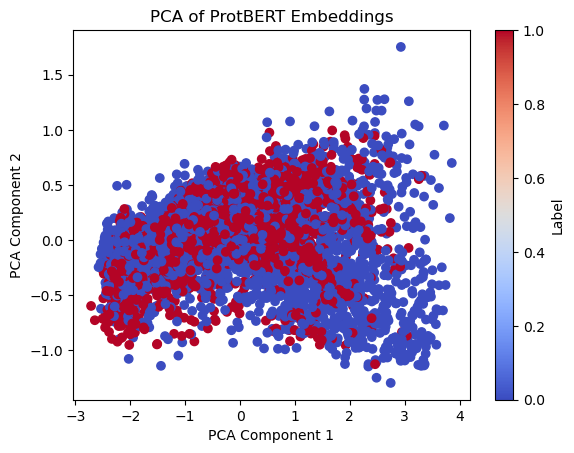

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_df.iloc[:, :-1])  

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=embedding_df["Label"], cmap='coolwarm')
plt.title("PCA of ProtBERT Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Label")
plt.show()

In [17]:
test_df["Tokenized_Sequence"] = test_df["Sequence"].apply(lambda x: " ".join(list(x)))

print(test_df[["Protein_ID", "Tokenized_Sequence", "Label"]].head())

      Protein_ID                                 Tokenized_Sequence  Label
0  allergen_2145  M V K N L P P S V R E Q C I E S Q I V I R D C ...      1
1   allergen_109  M K F F A V L A L C I V G A I A S P L T A D E ...      1
2  allergen_2419  M S K A R V Y T D V N V L R P K E Y W D Y E A ...      1
3    allergen_12  M A K L V L S L C F L L F S G C C F A F S F R ...      1
4   allergen_117  M K I V L A I A S L L A L S A V Y A R P S S I ...      1


In [18]:
test_df["Tokenized_Sequence"] = test_df["Sequence"].apply(lambda x: " ".join(list(x)))

embeddings_test = []

for seq in tqdm(test_df["Tokenized_Sequence"]):
    emb = get_protbert_embeddings(seq)
    embeddings_test.append(emb)

embeddings_array = np.array(embeddings)

np.save("Dataset/protbert_test_embeddings.npy", embeddings_array)

print("ProtBERT embeddings Shape:", embeddings_array.shape)

100%|██████████| 1420/1420 [12:05<00:00,  1.96it/s]

ProtBERT embeddings Shape: (5680, 1024)


In [25]:
train_label_counts = train_df["Label"].value_counts()
print("Train Set Label Distribution:")
print(train_label_counts)

test_label_counts = test_df["Label"].value_counts()
print("\nTest Set Label Distribution:")
print(test_label_counts)

Train Set Label Distribution:
Label
0    2840
1    2840
Name: count, dtype: int64

Test Set Label Distribution:
Label
0    2840
1    2840
Name: count, dtype: int64


In [26]:
print(train_df.duplicated().sum(), test_df.duplicated().sum())

0 0


In [30]:
print(train_df.columns)
print(test_df.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023',
       'Label'],
      dtype='object', length=1025)
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023',
       'Label'],
      dtype='object', length=1025)


In [35]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Label
0,0.086905,0.064474,-0.012450,-0.037899,0.003578,-0.016869,0.031366,0.044413,-0.022268,-0.013294,...,0.014594,0.015101,-0.033381,-0.023159,-0.003469,-0.073165,-0.049568,0.002033,0.016894,0
1,0.067527,-0.009051,-0.007344,-0.038439,0.023209,0.011579,0.001814,0.032845,0.027436,0.008903,...,-0.005045,0.034608,-0.091185,-0.030919,-0.043191,-0.052509,-0.061765,0.025321,0.001051,0
2,0.106294,0.020479,0.037305,0.009191,0.064401,0.007766,0.004668,0.011003,0.040737,-0.009711,...,-0.004814,0.022652,0.000608,-0.045922,-0.037261,-0.057934,-0.036676,-0.045970,-0.019217,0
3,0.010107,0.028703,-0.031847,-0.042281,0.062848,-0.029239,0.010851,0.019762,0.009444,0.031312,...,0.020512,0.035028,-0.004533,-0.044993,-0.049837,-0.053299,-0.055925,-0.010627,0.023868,1
4,0.003830,-0.030011,0.043521,-0.019920,-0.036928,-0.006020,-0.007284,-0.016183,-0.008275,0.007242,...,0.031610,-0.044113,-0.031392,0.020649,0.007634,0.008333,0.009560,-0.002700,0.064265,0


In [31]:
train_df_processed = pd.read_csv("Dataset/processed_for_bert_train.csv")
test_df_processed = pd.read_csv("Dataset/processed_for_bert_test.csv")

In [32]:
overlap = set(train_df_processed["Sequence"]).intersection(set(test_df_processed["Sequence"]))
print(f"Number of overlapping sequences: {len(overlap)}")

Number of overlapping sequences: 0


In [33]:
train_df_processed.columns

Index(['Protein_ID', 'Sequence', 'Label', 'Tokenized_Sequence'], dtype='object')

In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

train_embeddings = np.load("Dataset/protbert_train_embeddings.npy")

train_df = pd.read_csv("Dataset/protbert_train_embeddings.csv")
train_labels = train_df["Label"].values  # Extract labels

#scaler = StandardScaler()
#train_embeddings = scaler.fit_transform(train_embeddings)

log_reg = LogisticRegression()
log_reg.fit(train_embeddings, train_labels)

print("Logistic Regression model trained")

Logistic Regression model trained


/opt/homebrew/Caskroom/miniconda/base/envs/protein_allergy/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
test_embeddings = np.load("Dataset/protbert_test_embeddings.npy")

test_embeddings = scaler.transform(test_embeddings) 

test_df = pd.read_csv("Dataset/protbert_train_embeddings.csv")  
test_labels = test_df["Label"].values  

test_predictions = log_reg.predict(test_embeddings)

accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

print(classification_report(test_labels, test_predictions))

Test Accuracy: 0.9294
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2840
           1       0.92      0.94      0.93      2840

    accuracy                           0.93      5680
   macro avg       0.93      0.93      0.93      5680
weighted avg       0.93      0.93      0.93      5680



In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

train_embeddings = np.load("Dataset/protbert_train_embeddings.npy")
test_embeddings = np.load("Dataset/protbert_test_embeddings.npy")

train_df = pd.read_csv("Dataset/protbert_train_embeddings.csv")
test_df = pd.read_csv("Dataset/protbert_train_embeddings.csv")  # Adjust if needed

train_labels = train_df["Label"].values
test_labels = test_df["Label"].values


models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

for name, model in models.items():
    model.fit(train_embeddings, train_labels)
    predictions = model.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, predictions)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(test_labels, predictions))
    print("-" * 50)

/opt/homebrew/Caskroom/miniconda/base/envs/protein_allergy/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.9306
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2840
           1       0.93      0.94      0.93      2840

    accuracy                           0.93      5680
   macro avg       0.93      0.93      0.93      5680
weighted avg       0.93      0.93      0.93      5680

--------------------------------------------------
SVM Accuracy: 0.9275
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      2840
           1       0.92      0.94      0.93      2840

    accuracy                           0.93      5680
   macro avg       0.93      0.93      0.93      5680
weighted avg       0.93      0.93      0.93      5680

--------------------------------------------------
Random Forest Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2840
           1       1.00      1.00      1.00   

/opt/homebrew/Caskroom/miniconda/base/envs/protein_allergy/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:27:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2840
           1       1.00      1.00      1.00      2840

    accuracy                           1.00      5680
   macro avg       1.00      1.00      1.00      5680
weighted avg       1.00      1.00      1.00      5680

--------------------------------------------------
KNN Accuracy: 0.9426
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2840
           1       0.93      0.96      0.94      2840

    accuracy                           0.94      5680
   macro avg       0.94      0.94      0.94      5680
weighted avg       0.94      0.94      0.94      5680

--------------------------------------------------
Naive Bayes Accuracy: 0.7938
              precision    recall  f1-score   support

           0       0.86      0.70      0.77      2840
           1       0.75      0.89      0.81      2840

    a